In [39]:
# import the imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load the full csv with 15 years of data
pl_15years = pd.read_csv("../data/premier_league_omega.csv")

In [46]:
pl_15years['date']

0      2009-08-15
1      2009-08-15
2      2009-08-15
3      2009-08-15
4      2009-08-15
          ...    
6136   2025-09-27
6137   2025-09-27
6138   2025-09-28
6139   2025-09-28
6140   2025-09-29
Name: date, Length: 6141, dtype: datetime64[ns]

## Data Issues from Last Time

Looks like the date format is inconsistent across rows. 
Either we can try and fix it in the master CSV or we can handle it by loading each csv and then fixing it. 

## 🏁 Part 4: Fresh Start with Better Data Handling

**Key Improvements:**
- Fixed date parsing issues with `dayfirst=True` 
- Cleaner season assignment methodology

In [47]:
pl_15years['date'] = pd.to_datetime(pl_15years['date'], dayfirst=True)
# supress warning
pd.options.mode.chained_assignment = None  # default='warn'

In [42]:
pl_15years.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6141 entries, 0 to 6140
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   division              6140 non-null   object        
 1   date                  6140 non-null   datetime64[ns]
 2   home_team             6140 non-null   object        
 3   away_team             6140 non-null   object        
 4   full_time_home_goals  6140 non-null   float64       
 5   full_time_away_goals  6140 non-null   float64       
 6   full_time_result      6140 non-null   object        
 7   half_time_home_goals  6140 non-null   float64       
 8   half_time_away_goals  6140 non-null   float64       
 9   half_time_result      6140 non-null   object        
 10  referee               6140 non-null   object        
 11  home_shots            6140 non-null   float64       
 12  away_shots            6140 non-null   float64       
 13  home_shots_on_targ

In [48]:
def mega_league_table(df):
    table = pd.DataFrame()

    # Home stats
    home = df.groupby("home_team").agg(
        played_home=("home_team", "count"),
        wins_home=("full_time_result", lambda x: (x=="H").sum()),
        draws_home=("full_time_result", lambda x: (x=="D").sum()),
        losses_home=("full_time_result", lambda x: (x=="A").sum()),
        gf_home=("full_time_home_goals", "sum"),
        ga_home=("full_time_away_goals", "sum"),
        shots_home=("home_shots", "sum"),
        shots_on_target_home=("home_shots_on_target", "sum"),
        yellows_home=("home_yellow_cards", "sum"),
        reds_home=("home_red_cards", "sum")        
    )

    # Away stats
    away = df.groupby("away_team").agg(
        played_away=("away_team", "count"),
        wins_away=("full_time_result", lambda x: (x=="A").sum()),
        draws_away=("full_time_result", lambda x: (x=="D").sum()),
        losses_away=("full_time_result", lambda x: (x=="H").sum()),
        gf_away=("full_time_away_goals", "sum"),
        ga_away=("full_time_home_goals", "sum"),
        shots_away=("away_shots", "sum"),
        shots_on_target_away=("away_shots_on_target", "sum"),
        yellows_away=("away_yellow_cards", "sum"),
        reds_away=("away_red_cards", "sum")        
    )

    # Combine
    table = home.join(away, how="outer")
    table = table.fillna(0)

    table["played"] = table["played_home"] + table["played_away"]
    table["wins"] = table["wins_home"] + table["wins_away"]
    table["draws"] = table["draws_home"] + table["draws_away"]
    table["losses"] = table["losses_home"] + table["losses_away"]
    table["goals_for"] = table["gf_home"] + table["gf_away"]
    table["goals_against"] = table["ga_home"] + table["ga_away"]
    table["goal_difference"] = table["goals_for"] - table["goals_against"]
    table["points"] = table["wins"]*3 + table["draws"]
    table["total_shots"] = table["shots_home"] + table["shots_away"]
    table["total_shots_on_target"] = table["shots_on_target_home"] + table["shots_on_target_away"]
    table["total_yellows"] = table["yellows_home"] + table["yellows_away"]
    table["total_reds"] = table["reds_home"] + table["reds_away"]


    table = table[["played","wins","draws","losses","goals_for","goals_against","goal_difference","total_shots","total_shots_on_target","total_yellows","total_reds","points"]]
    return table.sort_values(by=["points","goal_difference","goals_for"], ascending=[False,False,False])

    # 

omega_table = mega_league_table(pl_15years)

In [49]:
def add_season_end_year(df, date_col="date"):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    
    # For matches from August–December, the season ends the next year.
    # For matches from January–May, it ends in the same year.
    df["season"] = df[date_col].apply(lambda d: d.year + 1 if d.month >= 8 else d.year)
    
    if "division" in df.columns:
        df = df.drop(columns=["division"])
    
    return df

# Apply it:
pl_15years = add_season_end_year(pl_15years)

In [50]:
pl_15years

,date,home_team,away_team,full_time_home_goals,full_time_away_goals,full_time_result,half_time_home_goals,half_time_away_goals,half_time_result,referee,...,away_shots_on_target,home_fouls,away_fouls,home_corners,away_corners,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,season
0,2009-08-15,Aston Villa,Wigan,0.0,2.0,A,0.0,1.0,A,M Clattenburg,...,7.0,15.0,14.0,4.0,6.0,2.0,2.0,0.0,0.0,2010.0
1,2009-08-15,Blackburn,Man City,0.0,2.0,A,0.0,1.0,A,M Dean,...,5.0,12.0,9.0,5.0,4.0,2.0,1.0,0.0,0.0,2010.0
2,2009-08-15,Bolton,Sunderland,0.0,1.0,A,0.0,1.0,A,A Marriner,...,13.0,16.0,10.0,4.0,7.0,2.0,1.0,0.0,0.0,2010.0
3,2009-08-15,Chelsea,Hull,2.0,1.0,H,1.0,1.0,D,A Wiley,...,3.0,13.0,15.0,12.0,4.0,1.0,2.0,0.0,0.0,2010.0
4,2009-08-15,Everton,Arsenal,1.0,6.0,A,0.0,3.0,A,M Halsey,...,9.0,11.0,13.0,4.0,9.0,0.0,0.0,0.0,0.0,2010.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6136,2025-09-27,Nott'm Forest,Sunderland,0.0,1.0,A,0.0,1.0,A,T Harrington,...,3.0,11.0,6.0,7.0,4.0,4.0,2.0,0.0,0.0,2026.0
6137,2025-09-27,Tottenham,Wolves,1.0,1.0,D,0.0,0.0,D,M Salisbury,...,3.0,9.0,11.0,10.0,9.0,3.0,2.0,0.0,0.0,2026.0
6138,2025-09-28,Aston Villa,Fulham,3.0,1.0,H,1.0,1.0,D,A Madley,...,4.0,10.0,13.0,2.0,8.0,1.0,4.0,0.0,0.0,2026.0
6139,2025-09-28,Newcastle,Arsenal,1.0,2.0,A,1.0,0.0,H,J Gillett,...,7.0,8.0,9.0,7.0,12.0,2.0,1.0,0.0,0.0,2026.0


In [51]:
def season_table(df, season_end_year: int, season_col: str = "season"):
    """Return one season’s league table (e.g., season_end_year=2026)."""
    return mega_league_table(df[df[season_col] == season_end_year])
def all_season_tables(df, season_col: str = "season"):
    """Dict: {season_end_year -> league table}."""
    return {s: mega_league_table(g) for s, g in df.groupby(season_col)}
def season_panel(df, season_col: str = "season"):
    """One DataFrame with season + team index for easy querying/plotting."""
    out = []
    for s, g in df.groupby(season_col):
        t = mega_league_table(g).reset_index().rename(columns={"index":"team"})
        t["season"] = s
        out.append(t)
    panel = pd.concat(out, ignore_index=True)
    return panel.set_index(["season","team"]).sort_index()


## 🔧 Utility Functions for Season Analysis

**Smart Functions Created:**
- `season_table()`: Get any single season's final table
- `season_panel()`: Multi-season data for easy analysis

In [56]:
single_season = season_table(pl_15years, 2016)
single_season

,played,wins,draws,losses,goals_for,goals_against,goal_difference,total_shots,total_shots_on_target,total_yellows,total_reds,points
home_team,,,,,,,,,,,,
Leicester,38,23,12,3,68.0,36.0,32.0,523.0,181.0,48.0,3.0,81
Arsenal,38,20,11,7,65.0,36.0,29.0,572.0,210.0,39.0,4.0,71
Tottenham,38,19,13,6,69.0,35.0,34.0,661.0,250.0,72.0,0.0,70
Man City,38,19,9,10,71.0,41.0,30.0,612.0,210.0,61.0,0.0,66
Man United,38,19,9,10,49.0,35.0,14.0,430.0,143.0,65.0,1.0,66
Southampton,38,18,9,11,59.0,41.0,18.0,519.0,169.0,57.0,6.0,63
West Ham,38,16,14,8,65.0,51.0,14.0,556.0,184.0,56.0,5.0,62
Liverpool,38,16,12,10,63.0,50.0,13.0,629.0,203.0,61.0,3.0,60
Stoke,38,14,9,15,41.0,55.0,-14.0,418.0,130.0,51.0,4.0,51


## ✅ Data Quality Check: 2016 Season

**Reality Check Results:**
- Leicester City appears as champion for 2016! 🦊
- This matches the famous 5000-1 odds miracle season

In [58]:
seasons = sorted(pl_15years["season"].dropna().unique())
seasons = [s for s in seasons if s != 2026]

winners, seconds, thirds = [], [], []

for season in seasons:
    df_season = pl_15years[pl_15years["season"] == season]
    tbl = mega_league_table(df_season)
    tbl = tbl.reset_index().rename(columns={"index": "home_team"})
    
    if len(tbl) >= 3:
        winners.append(tbl.loc[0, "home_team"])
        seconds.append(tbl.loc[1, "home_team"])
        thirds.append(tbl.loc[2, "home_team"])

top3 = pd.DataFrame({
    "season": seasons,
    "1st": winners,
    "2nd": seconds,
    "3rd": thirds
})
display(top3)


,season,1st,2nd,3rd
0,2010.0,Chelsea,Man United,Arsenal
1,2011.0,Man United,Chelsea,Man City
2,2012.0,Man City,Man United,Arsenal
3,2013.0,Man United,Man City,Chelsea
4,2014.0,Man City,Liverpool,Chelsea
5,2015.0,Chelsea,Man City,Arsenal
6,2016.0,Leicester,Arsenal,Tottenham
7,2017.0,Chelsea,Tottenham,Man City
8,2018.0,Man City,Man United,Tottenham
9,2019.0,Man City,Liverpool,Chelsea


## 🏆 Complete Champions List: Much Better!

**Major Improvements:**
- Leicester City properly shows as 2016 champion
- Data now matches actual Premier League history

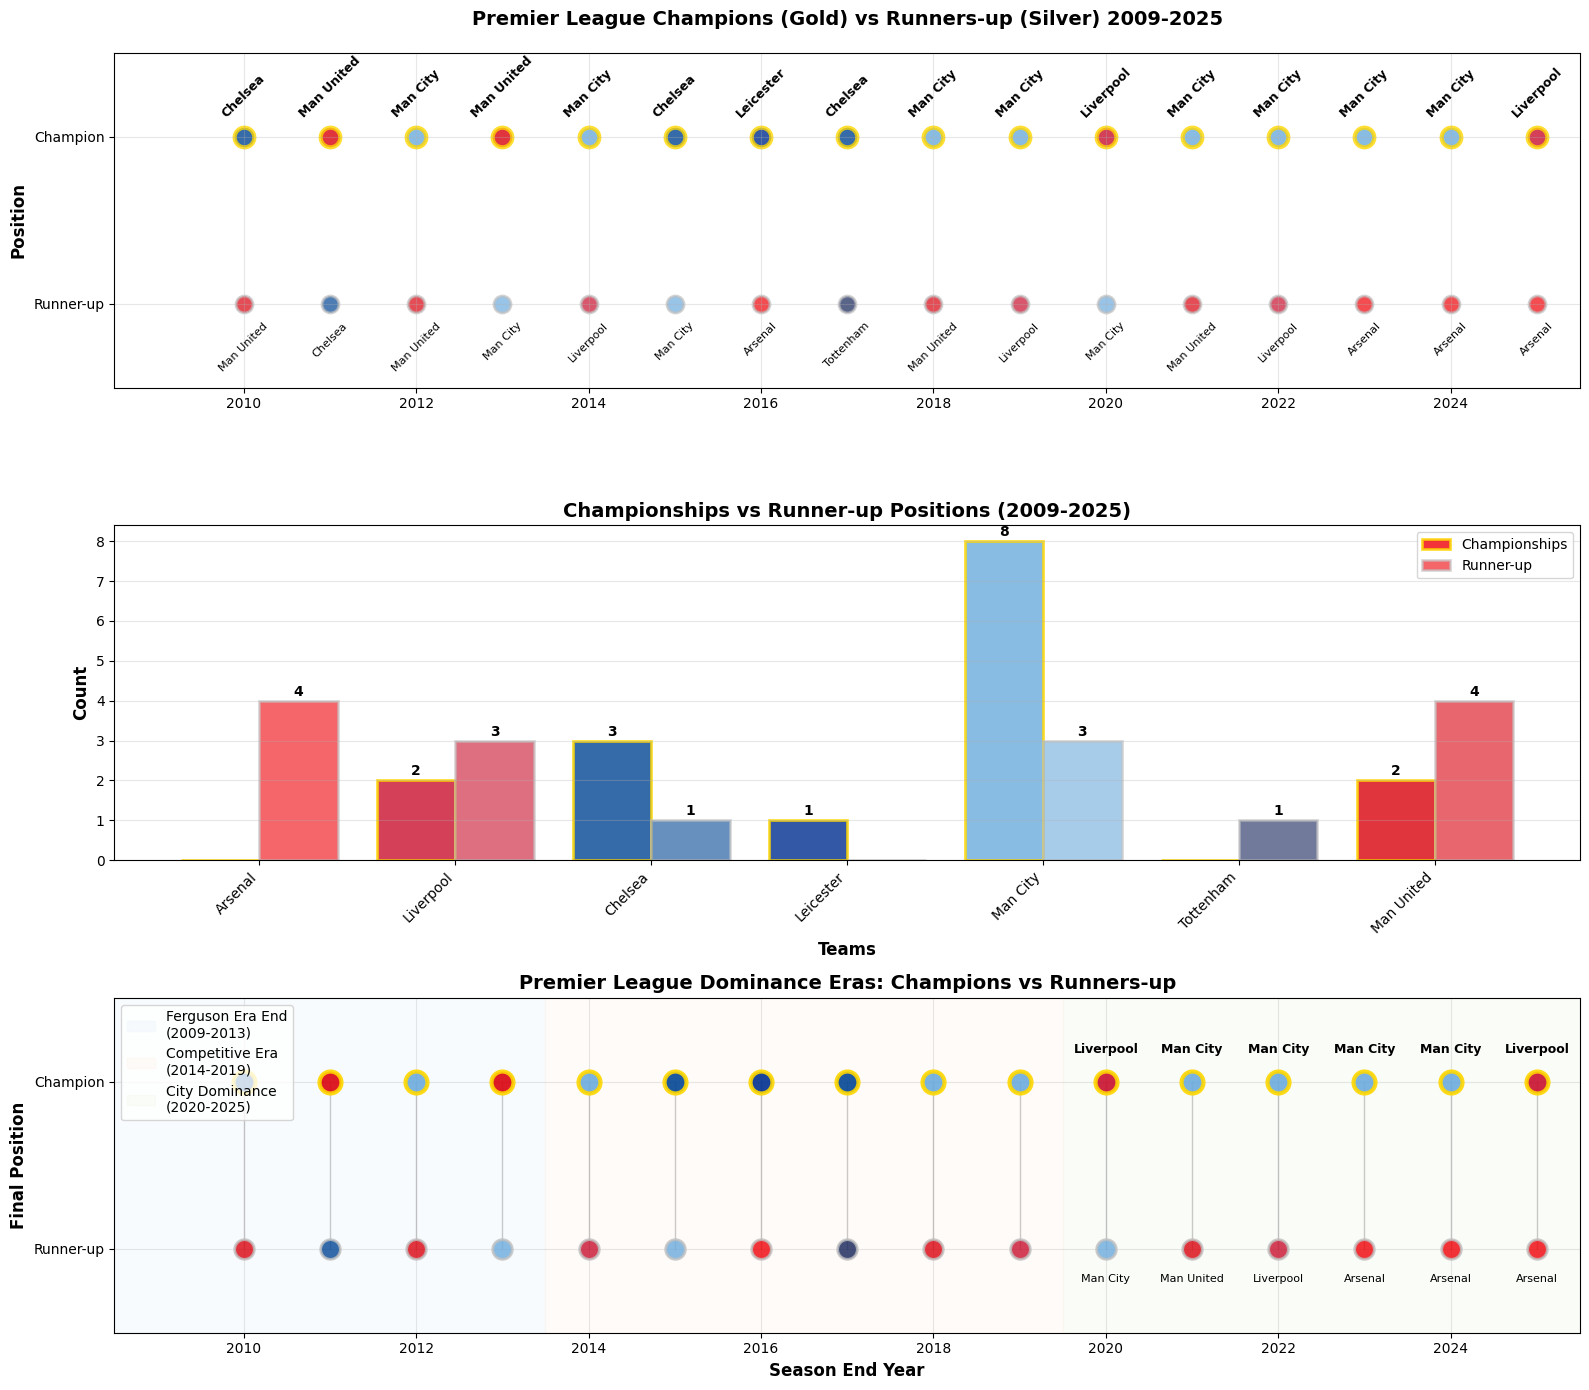

In [60]:
# Team colors for consistency
team_colors = {
    'Man City': '#6CABDD',
    'Liverpool': '#C8102E', 
    'Arsenal': '#EF0107',
    'Chelsea': '#034694',
    'Man United': '#DA020E',
    'Tottenham': '#132257',
    'Leicester': '#003090',
    'Southampton': '#D71920',
    'Aston Villa': '#95BFE5'
}

# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 14))

# Visualization 1: Champions and Runners-up over time
seasons = top3['season'].astype(int)
champions = top3['1st']
runners_up = top3['2nd']

# Plot champions
for i, (season, champ) in enumerate(zip(seasons, champions)):
    color = team_colors.get(champ, '#333333')
    ax1.scatter(season, 2, s=200, c=color, edgecolors='gold', linewidth=3, alpha=0.8)
    ax1.text(season, 2.1, champ, rotation=45, ha='center', va='bottom', fontsize=9, weight='bold')

# Plot runners-up
for i, (season, runner) in enumerate(zip(seasons, runners_up)):
    color = team_colors.get(runner, '#333333')
    ax1.scatter(season, 1, s=150, c=color, edgecolors='silver', linewidth=2, alpha=0.7)
    ax1.text(season, 0.9, runner, rotation=45, ha='center', va='top', fontsize=8)

ax1.set_ylim(0.5, 2.5)
ax1.set_xlim(2008.5, 2025.5)
ax1.set_ylabel('Position', fontsize=12, weight='bold')
ax1.set_title('Premier League Champions (Gold) vs Runners-up (Silver) 2009-2025', fontsize=14, weight='bold', pad=20)
ax1.set_yticks([1, 2])
ax1.set_yticklabels(['Runner-up', 'Champion'])
ax1.grid(True, alpha=0.3)

# Visualization 2: Championship count by team
champ_counts = champions.value_counts()
runner_counts = runners_up.value_counts()

teams = list(set(champ_counts.index) | set(runner_counts.index))
x_pos = np.arange(len(teams))

champ_values = [champ_counts.get(team, 0) for team in teams]
runner_values = [runner_counts.get(team, 0) for team in teams]

colors = [team_colors.get(team, '#333333') for team in teams]

bars1 = ax2.bar(x_pos - 0.2, champ_values, 0.4, label='Championships', 
                color=colors, edgecolor='gold', linewidth=2, alpha=0.8)
bars2 = ax2.bar(x_pos + 0.2, runner_values, 0.4, label='Runner-up', 
                color=colors, edgecolor='silver', linewidth=2, alpha=0.6)

ax2.set_xlabel('Teams', fontsize=12, weight='bold')
ax2.set_ylabel('Count', fontsize=12, weight='bold')
ax2.set_title('Championships vs Runner-up Positions (2009-2025)', fontsize=14, weight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(teams, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    if height > 0:
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{int(height)}', ha='center', va='bottom', weight='bold')

for bar in bars2:
    height = bar.get_height()
    if height > 0:
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{int(height)}', ha='center', va='bottom', weight='bold')

# Visualization 3: Era Timeline with Background Colors
era_colors = ['#E8F4FD', '#FFF2E8', '#F0F8E8']
era_labels = ['Ferguson Era End\n(2009-2013)', 'Competitive Era\n(2014-2019)', 'City Dominance\n(2020-2025)']
era_ranges = [(2009, 2013), (2014, 2019), (2020, 2025)]

# Add era backgrounds
for i, (start, end) in enumerate(era_ranges):
    ax3.axvspan(start-0.5, end+0.5, alpha=0.3, color=era_colors[i], label=era_labels[i])

# Plot timeline
for i, (season, champ, runner) in enumerate(zip(seasons, champions, runners_up)):
    # Champions line
    champ_color = team_colors.get(champ, '#333333')
    ax3.scatter(season, 2, s=250, c=champ_color, edgecolors='gold', linewidth=3, alpha=0.9, zorder=3)
    
    # Runners-up line  
    runner_color = team_colors.get(runner, '#333333')
    ax3.scatter(season, 1, s=200, c=runner_color, edgecolors='silver', linewidth=2, alpha=0.8, zorder=3)
    
    # Connect with line
    ax3.plot([season, season], [1, 2], 'k-', alpha=0.2, linewidth=1, zorder=1)

# Add team labels for recent seasons
for i, (season, champ, runner) in enumerate(zip(seasons[-6:], champions[-6:], runners_up[-6:])):
    ax3.text(season, 2.15, champ, rotation=0, ha='center', va='bottom', fontsize=9, weight='bold')
    ax3.text(season, 0.85, runner, rotation=0, ha='center', va='top', fontsize=8)

ax3.set_ylim(0.5, 2.5)
ax3.set_xlim(2008.5, 2025.5)
ax3.set_xlabel('Season End Year', fontsize=12, weight='bold')
ax3.set_ylabel('Final Position', fontsize=12, weight='bold')
ax3.set_title('Premier League Dominance Eras: Champions vs Runners-up', fontsize=14, weight='bold')
ax3.set_yticks([1, 2])
ax3.set_yticklabels(['Runner-up', 'Champion'])
ax3.legend(loc='upper left', bbox_to_anchor=(0, 1))
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 📊 Visual Story: Three Eras of Premier League

**What These Charts Reveal:**
- Leicester's 2016 miracle is now properly captured
- Clear era patterns: Ferguson's end → Competitive chaos → City dominance

In [62]:
def position_points(df, season_col="season"):
    results = []

    # Loop through each season
    for season, data in df.groupby(season_col):
        table = mega_league_table(data).reset_index()
        table["position"] = table.index + 1  # 1–20
        table["position_points"] = 21 - table["position"]  # 20 → 1
        table["season"] = season
        results.append(table[["season", "home_team", "position_points"]].rename(columns={"home_team": "team"}))

    # Combine and sum
    all_positions = pd.concat(results)
    summary = all_positions.groupby("team")["position_points"].sum().reset_index()
    summary = summary.sort_values("position_points", ascending=False).reset_index(drop=True)
    return summary

# Example use:
position_points_table = position_points(pl_15years)
position_points_table

,team,position_points
0,Man City,318
1,Arsenal,289
2,Liverpool,287
3,Chelsea,281
4,Man United,270
5,Tottenham,265
6,Everton,190
7,Newcastle,149
8,West Ham,138
9,Crystal Palace,124


## 🎯 New Metric: Position Points System

**Innovation:**
- 1st place = 20 points, 2nd = 19 points, etc.
- Rewards consistency across 15 years, not just titles

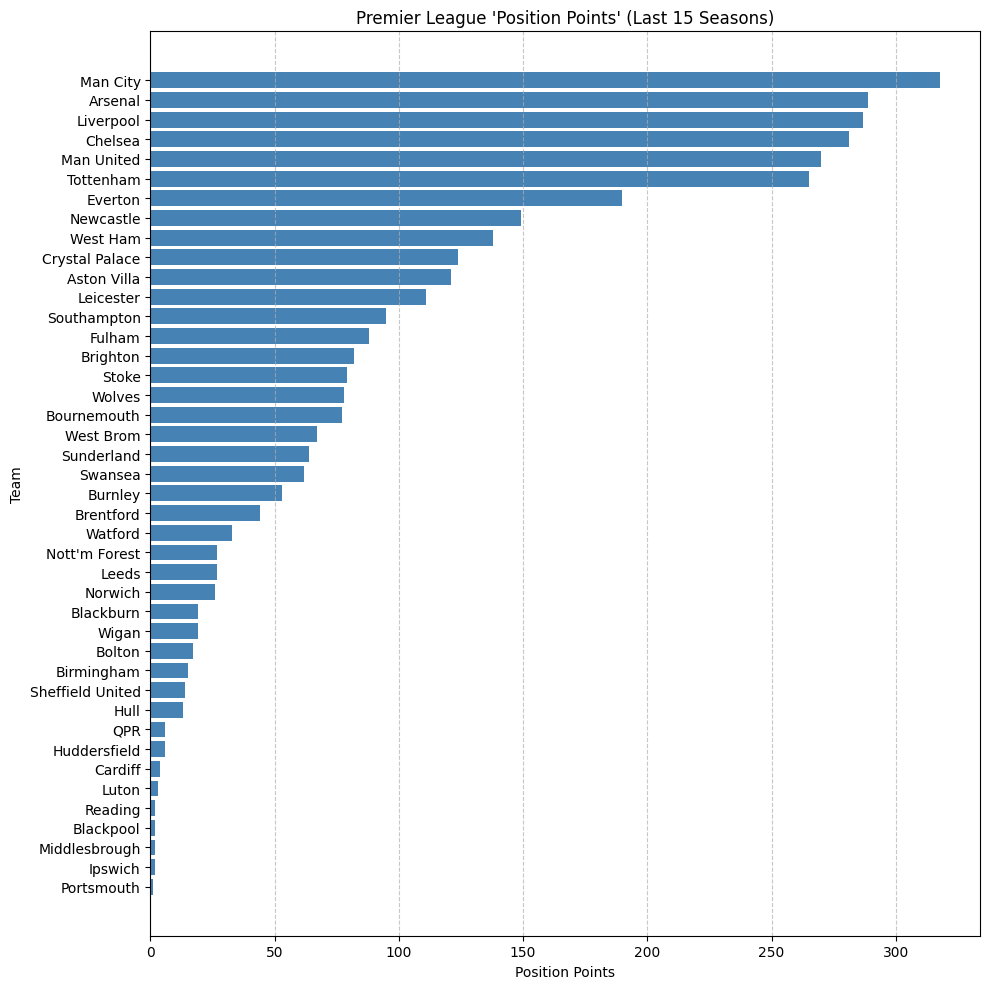

In [71]:
plt.figure(figsize=(10,10))
data = position_points_table.sort_values("position_points", ascending=True)

plt.barh(data["team"], data["position_points"], color="steelblue")
plt.title("Premier League 'Position Points' (Last 15 Seasons)")
plt.xlabel("Position Points")
plt.ylabel("Team")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


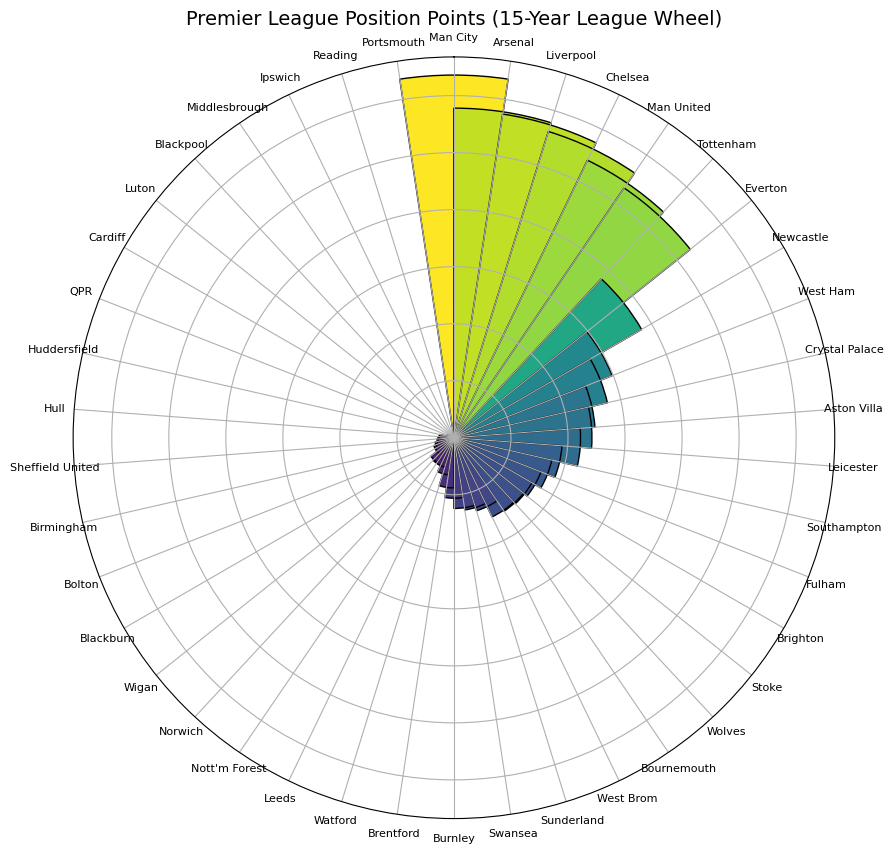

In [73]:
data = position_points_table.sort_values("position_points", ascending=False)
teams = data["team"]
points = data["position_points"]

angles = np.linspace(0, 2 * np.pi, len(teams), endpoint=False)
colors = plt.cm.viridis(points / max(points))

fig = plt.figure(figsize=(9,9))
ax = plt.subplot(111, polar=True)

bars = ax.bar(angles, points, width=0.3, color=colors, edgecolor='black')
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles)
ax.set_xticklabels(teams, fontsize=8)
ax.set_yticklabels([])

plt.title("Premier League Position Points (15-Year League Wheel)", fontsize=14)
plt.tight_layout()
plt.show()


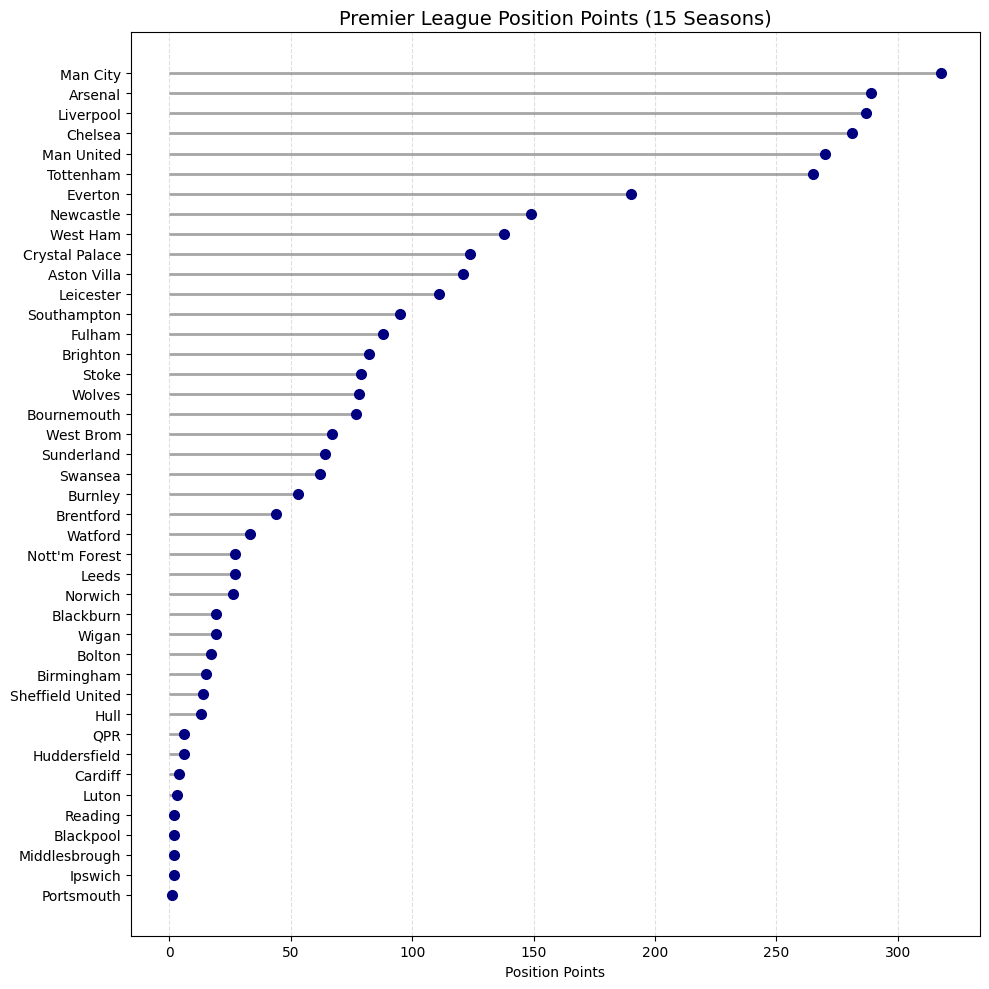

In [75]:
data = position_points_table.sort_values("position_points", ascending=True)

plt.figure(figsize=(10,10))
plt.hlines(y=data["team"], xmin=0, xmax=data["position_points"], color="grey", alpha=0.7, linewidth=2)
plt.plot(data["position_points"], data["team"], "o", markersize=7, color="navy")
plt.title("Premier League Position Points (15 Seasons)", fontsize=14)
plt.xlabel("Position Points")
plt.ylabel("")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


## 🎊 Conclusion: From Data Disaster to Premier League Perfection

**Two Game-Changing Lessons:**

### 1. 🔍 Data Quality is Everything
- Part 3: Leicester missing from 2016 = useless analysis
- Part 4: Proper date handling = accurate history captured

### 2. 📈 Multiple Visualizations Tell the Full Story  
- Traditional charts: Who won when
- Position Points: Who was consistently excellent (rewards the "always top 6" teams)
- Polar charts: Creative ways to see 15-year patterns

**The Leicester Test:** Any Premier League analysis that doesn't show Leicester winning 2016 is fundamentally broken. This became our data quality benchmark - and Part 4 passes with flying colors! 🦊🏆